In [ ]:
#mount the drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In [ ]:
filename = "/content/drive/My Drive/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
file = open(filename, 'r')
doc = file.read()

In [ ]:
doc

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
descriptions = dict()
	# process lines
for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in descriptions:
			descriptions[image_id] = list()
		# store description
		descriptions[image_id].append(image_desc)





In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
import string

In [ ]:
#clean descriptions:

# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)


In [ ]:
type(descriptions)

dict

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


In [ ]:
#set the root caption
root_captioning = "/content/drive/My Drive/Flickr8k"


In [ ]:
#imgages
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [ ]:
len(img)

8091

In [ ]:
#train set
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))

train_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
   




In [ ]:
#test set
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in test_images: 
    test_img.append(f) 
  


In [ ]:
print(len(train_images))
print(len(test_images))

6000
1000


In [ ]:
#creating train descriptions:
START = "startseq"
STOP = "endseq"

train_descriptions = {k:v for k,v in descriptions.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'



In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
# using InceptionV3 model trained on imagenet data
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

96116736/96112376 [==============================] - 2s 0us/step


In [ ]:
encode_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#function to encode the image:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 
  x = preprocess_input(x)
  # Call InceptionV3 to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [ ]:
#encoding train
encoding_train = {}
for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  

100%|██████████| 6000/6000 [52:07<00:00,  1.92it/s]


In [ ]:
# save the encode_train.
dump(encoding_train, open('encoding_train_features.pkl', 'wb'))

In [ ]:
#loading the encode_train.
encoding_train = pickle.load(open('encoding_train_features.pkl', 'rb'))

In [ ]:
encoding_train['1000268201_693b08cb0e.jpg']

array([0.12277617, 0.33294934, 0.7527172 , ..., 0.21939719, 0.3021645 ,
       0.40283197], dtype=float32)

In [ ]:
#encoding test
encoding_test = {}
for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
 


100%|██████████| 1000/1000 [08:42<00:00,  1.91it/s]


In [ ]:
# save the encode_test.
dump(encoding_test, open('encoding_test_features.pkl', 'wb'))

In [ ]:
#load the encode_test
encoding_test = pickle.load(open('encoding_test_features.pkl', 'rb'))

In [ ]:
encoding_test['1056338697_4f7d7ce270.jpg']

array([0.45309213, 0.257523  , 0.11301489, ..., 1.1222707 , 0.34380376,
       1.0150979 ], dtype=float32)

In [ ]:
#since we are building a pedictive model, we need the words that are repeted certain amount of times,so we select the threshold to be 10.
#first convert the descriptions, into list
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)


30000

In [ ]:
#setting threshold to be 10, and selecting the words repeated more than 10 times.
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [ ]:
vocab[1:10]

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of']

In [ ]:
#creating word to index and index to word for the word.
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [ ]:
wordtoidx.items()


dict_items([('startseq', 1), ('child', 2), ('in', 3), ('pink', 4), ('dress', 5), ('is', 6), ('climbing', 7), ('up', 8), ('set', 9), ('of', 10), ('stairs', 11), ('an', 12), ('way', 13), ('endseq', 14), ('girl', 15), ('going', 16), ('into', 17), ('wooden', 18), ('building', 19), ('little', 20), ('the', 21), ('to', 22), ('her', 23), ('black', 24), ('dog', 25), ('and', 26), ('spotted', 27), ('are', 28), ('fighting', 29), ('tricolored', 30), ('playing', 31), ('with', 32), ('each', 33), ('other', 34), ('on', 35), ('road', 36), ('white', 37), ('brown', 38), ('spots', 39), ('staring', 40), ('at', 41), ('street', 42), ('two', 43), ('dogs', 44), ('different', 45), ('looking', 46), ('pavement', 47), ('moving', 48), ('toward', 49), ('covered', 50), ('paint', 51), ('sits', 52), ('front', 53), ('painted', 54), ('rainbow', 55), ('hands', 56), ('bowl', 57), ('sitting', 58), ('large', 59), ('small', 60), ('grass', 61), ('plays', 62), ('it', 63), ('there', 64), ('pigtails', 65), ('painting', 66), ('youn

In [ ]:
idxtoword.items()

dict_items([(1, 'startseq'), (2, 'child'), (3, 'in'), (4, 'pink'), (5, 'dress'), (6, 'is'), (7, 'climbing'), (8, 'up'), (9, 'set'), (10, 'of'), (11, 'stairs'), (12, 'an'), (13, 'way'), (14, 'endseq'), (15, 'girl'), (16, 'going'), (17, 'into'), (18, 'wooden'), (19, 'building'), (20, 'little'), (21, 'the'), (22, 'to'), (23, 'her'), (24, 'black'), (25, 'dog'), (26, 'and'), (27, 'spotted'), (28, 'are'), (29, 'fighting'), (30, 'tricolored'), (31, 'playing'), (32, 'with'), (33, 'each'), (34, 'other'), (35, 'on'), (36, 'road'), (37, 'white'), (38, 'brown'), (39, 'spots'), (40, 'staring'), (41, 'at'), (42, 'street'), (43, 'two'), (44, 'dogs'), (45, 'different'), (46, 'looking'), (47, 'pavement'), (48, 'moving'), (49, 'toward'), (50, 'covered'), (51, 'paint'), (52, 'sits'), (53, 'front'), (54, 'painted'), (55, 'rainbow'), (56, 'hands'), (57, 'bowl'), (58, 'sitting'), (59, 'large'), (60, 'small'), (61, 'grass'), (62, 'plays'), (63, 'it'), (64, 'there'), (65, 'pigtails'), (66, 'painting'), (67, '

In [ ]:
# Finding the maximum length of a caption 

# function to convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
 all_desc = list()
 for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]
 return all_desc

# function to return the max lenghth
def max_length(descriptions):
 lines = to_lines(descriptions)
 return max(len(d.split()) for d in lines)



In [ ]:
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Max Description Length:',max_length)


Max Description Length: 34


In [ ]:
#creating a data generator.
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [ ]:
#For all the  unique words in our vocabulary, we create an embedding matrix which will be loaded into the model before training.
#loading the glove model
glove_dir = os.path.join(root_captioning,'data')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 17048.15it/s]

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

In [ ]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)




In [ ]:
caption_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
caption_model.layers[2]

In [ ]:
#using the weights of glove model
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False



In [ ]:
#compiling the model
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
EPOCHS = 20
#use more epochs if u have a better system!
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [ ]:
for i in tqdm(range(EPOCHS)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_batch)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/20 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.fit, which supports generators.
2000/2000 [==============================] - 162s 81ms/step - loss: 4.1254


  5%|▌         | 1/20 [02:46<52:46, 166.65s/it]

2000/2000 [==============================] - 165s 82ms/step - loss: 3.4263


 10%|█         | 2/20 [05:31<49:51, 166.18s/it]

2000/2000 [==============================] - 166s 83ms/step - loss: 3.2079


 15%|█▌        | 3/20 [08:17<47:05, 166.19s/it]

2000/2000 [==============================] - 169s 85ms/step - loss: 3.0763


 20%|██        | 4/20 [11:07<44:35, 167.22s/it]

2000/2000 [==============================] - 172s 86ms/step - loss: 2.9805


 25%|██▌       | 5/20 [13:59<42:10, 168.69s/it]

2000/2000 [==============================] - 158s 79ms/step - loss: 2.9063


 30%|███       | 6/20 [16:37<38:37, 165.51s/it]

2000/2000 [==============================] - 158s 79ms/step - loss: 2.8505


 35%|███▌      | 7/20 [19:16<35:24, 163.44s/it]

2000/2000 [==============================] - 161s 81ms/step - loss: 2.8006


 40%|████      | 8/20 [21:57<32:33, 162.83s/it]

2000/2000 [==============================] - 165s 82ms/step - loss: 2.7576


 45%|████▌     | 9/20 [24:42<29:57, 163.39s/it]

2000/2000 [==============================] - 159s 80ms/step - loss: 2.7248


 50%|█████     | 10/20 [27:21<27:01, 162.19s/it]

2000/2000 [==============================] - 163s 82ms/step - loss: 2.6960


 55%|█████▌    | 11/20 [30:05<24:22, 162.53s/it]

2000/2000 [==============================] - 158s 79ms/step - loss: 2.6698


 60%|██████    | 12/20 [32:43<21:30, 161.36s/it]

2000/2000 [==============================] - 160s 80ms/step - loss: 2.6452


 65%|██████▌   | 13/20 [35:24<18:47, 161.14s/it]

2000/2000 [==============================] - 160s 80ms/step - loss: 2.6246


 70%|███████   | 14/20 [38:04<16:05, 160.84s/it]

2000/2000 [==============================] - 157s 79ms/step - loss: 2.6059


 75%|███████▌  | 15/20 [40:42<13:19, 159.86s/it]

2000/2000 [==============================] - 161s 80ms/step - loss: 2.5880


 80%|████████  | 16/20 [43:22<10:40, 160.13s/it]

2000/2000 [==============================] - 159s 79ms/step - loss: 2.5740


 85%|████████▌ | 17/20 [46:01<07:59, 159.77s/it]

2000/2000 [==============================] - 159s 80ms/step - loss: 2.5600


 90%|█████████ | 18/20 [48:41<05:19, 159.62s/it]

2000/2000 [==============================] - 158s 79ms/step - loss: 2.5452


 95%|█████████▌| 19/20 [51:19<02:39, 159.30s/it]

2000/2000 [==============================] - 162s 81ms/step - loss: 2.5339


100%|██████████| 20/20 [54:01<00:00, 162.09s/it]


In [ ]:
#save model weights.
caption_model.save_weights('finalmodel.hdf5')

In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/drive/My Drive/Flickr8k/Flicker8k_Dataset/2345984157_724823b1e4.jpg


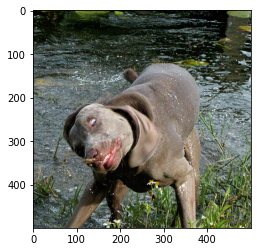

Caption: dog is shaking water off of itself
_____________________________________
/content/drive/My Drive/Flickr8k/Flicker8k_Dataset/3591462960_86045906bd.jpg


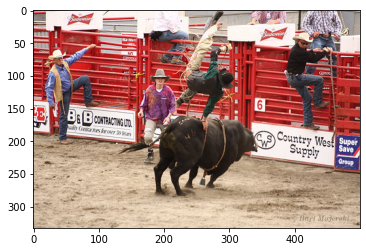

Caption: two dogs are running on the grass
_____________________________________
/content/drive/My Drive/Flickr8k/Flicker8k_Dataset/3234115903_f4dfc8fc75.jpg


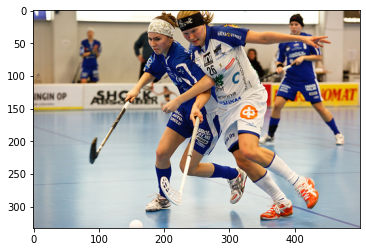

Caption: two men are playing basketball on the court
_____________________________________
/content/drive/My Drive/Flickr8k/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg


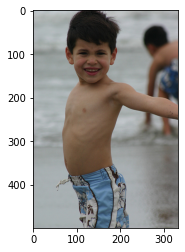

Caption: boy in red shorts is jumping into the water
_____________________________________
/content/drive/My Drive/Flickr8k/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg


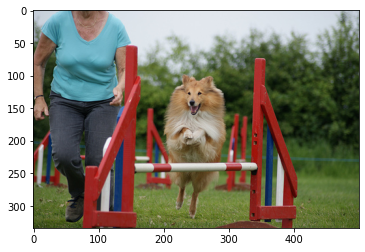

Caption: small child in red shirt is running through the grass
_____________________________________


In [ ]:
#testing the model on the test images!!!
for z in range(5):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

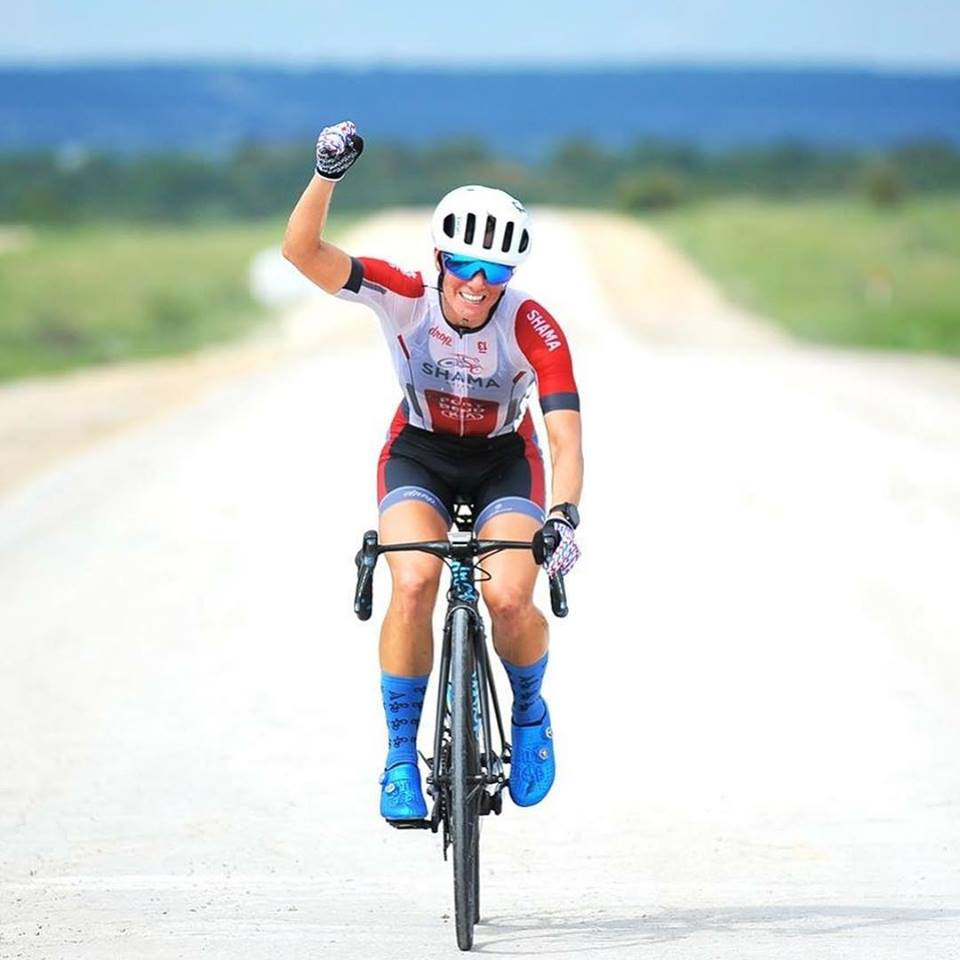

In [ ]:
#testing the model on the individual image!
img3 = Image.open('NicoleWinning.jpg')
img3

In [ ]:
img3 = encodeImage(img3).reshape((1,OUTPUT_DIM))

In [ ]:
print("Caption:",generateCaption(img3))

Caption: man in red shirt and helmet is riding bicycle in the woods
